# Imports

In [41]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import model_selection 
from sklearn import metrics
from sklearn import pipeline

# Custom Functions

## Plot Predictions by Observation
Display comparision of actual (blue dot) and predicted (red square) response variables for specified observations.

In [44]:
def act_v_pred(observations, actual, predicted, target_label):
    
    with plt.style.context(('fivethirtyeight')):

        fig, ax = plt.subplots(figsize=(10, 7))

        ax.scatter(observations, actual, c='b', label='actual')
        ax.scatter(observations, predicted, c='r', marker='s', label='predicted')
        ax.set_title('Observation vs Response')
        ax.set_xlabel('Observation')
        ax.set_ylabel(target_label)
        ax.legend(loc='upper left')

## Plot Predictions by Feature Value
Display comparision of actual (blue dot) and predicted (red square) response variables based on a single feature. Prediction trendline shown in red.

In [45]:
def pred_plot(predictors, predictor_label, response, response_label, predictions):
    
    with plt.style.context(('fivethirtyeight')):

        fig, ax = plt.subplots(figsize=(10, 7))

        ax.scatter(predictors, response, c='b', label='actual')
        ax.scatter(predictors, predictions, c='r', marker='s', label='predicted')
        z = np.polyfit(predictors, predictions, 1)
        p = np.poly1d(z)
        ax.plot(predictors, p(predictors), "r-", linewidth=1)
        ax.set_title('Predictor vs Response')
        ax.set_xlabel(predictor_label)
        ax.set_ylabel(response_label)
        ax.legend(loc='upper left')

## Plot residuals
Create two plots of:
1. Predicted vs Actual Values
2. Predicted Values vs Residuals

In [46]:
def res_plot(response, predictions):
    
    residuals = response - predictions
    
    with plt.style.context(('fivethirtyeight')):

        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
        
        ax1.scatter(predictions, response)
        ax1.set_title('Accuracy Plot')
        ax1.set_xlabel('Predicted Value')
        ax1.set_ylabel('Actual Value')

        ax2.scatter(predictions, residuals)
        ax2.set_title('Residual Plot')
        ax2.set_xlabel('Predicted Value')
        ax2.set_ylabel('Residuals')

## Ridge Regularization
Regularize linear regression model using L2 method and plot validation curves

In [47]:
class RegularizeLRModel():
    '''
    Methods:
        val_score
        val_curve
        test_model
    '''
    
    def __init__(self, X_train, y_train, alphas, method="Ridge"):
        
        self.X_train = X_train
        self.y_train = y_train
        self.alphas = alphas
        self.method = method
        
        # initialize empty lists for train and val scores and coefs
        self.train_error = []
        self.val_error = []
        self.coefs = []
    
    
    def val_score(self, n_steps=100, cv=10):
        '''
        Cross validation of linear regression model with Ridge regularization
        Calculates mean squared error for different alphas
        Returns coefficients for each alpha value (.coefs)
        Returns best alpha value for model (.best_alpha)
        '''
        
        for alpha in self.alphas:
            
            if self.method == "Ridge":
                # initialize linear regression model with Ridge regularization
                self.reg_model = linear_model.Ridge(alpha=alpha)
            elif self.method == "Lasso":
                self.reg_model = linear_model.Lasso(alpha=alpha)
            elif self.method == "Elastic":
                self.reg_model = linear_model.ElasticNet(alpha=alpha)
                
            # run cross validation on model
            cv_mod = model_selection.cross_validate(self.reg_model, self.X_train, self.y_train, 
                                               cv=cv, scoring='neg_mean_squared_error', return_train_score=True)
            # initialize minimum error
            if alpha == self.alphas[0]:
                min_err = -np.mean(cv_mod['test_score'])
                self.best_alpha = alpha
                
            # append train and validation mean squared errors
            self.train_error.append(-np.mean(cv_mod['train_score']))
            self.val_error.append(-np.mean(cv_mod['test_score']))
        
            # fit model on training data
            self.reg_model.fit(self.X_train, self.y_train)
            # append coefficients
            self.coefs.append(self.reg_model.coef_)
            
            # check if min error
            if -np.mean(cv_mod['test_score']) < min_err:
                min_err = -np.mean(cv_mod['test_score'])
                self.best_alpha = alpha
    
    
    def val_curve(self):
        
        with plt.style.context(('fivethirtyeight')):

            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,20))

            axes[0].plot(self.alphas, self.train_error, label="Train", c='b')
            axes[0].plot(self.alphas, self.val_error, label="Validation", c='r')
            axes[0].axvline(x=self.best_alpha, linewidth=2, linestyle='dashed')
            axes[0].set_ylabel("Mean Squared Error")
            axes[0].set_xlabel("Alpha Value")
            axes[0].legend(loc='upper right')

            axes[1].plot(self.alphas, self.coefs)
            axes[1].axvline(x=self.best_alpha, linewidth=2, linestyle='dashed')
            axes[1].set_ylabel("Coefficient Value")
            axes[1].set_xlabel("Alpha Value")

# Property Example

Read in data

In [48]:
df = pd.read_csv('data/ex1data2.txt', header=None)
df.columns = ['size', 'bed_num', 'price']

In [49]:
df.head()

,size,bed_num,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


## Plot Features vs Target

Text(0,0.5,'Price ($)')

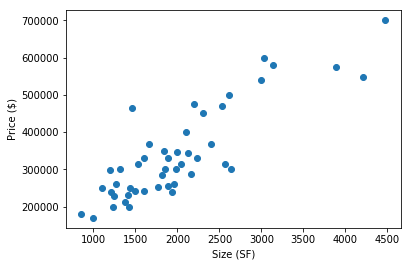

In [50]:
plt.scatter(df['size'], df['price'])
plt.xlabel('Size (SF)')
plt.ylabel('Price ($)')

Text(0,0.5,'Price ($)')

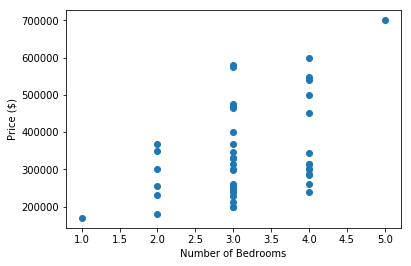

In [51]:
plt.scatter(df['bed_num'], df['price'])
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price ($)')

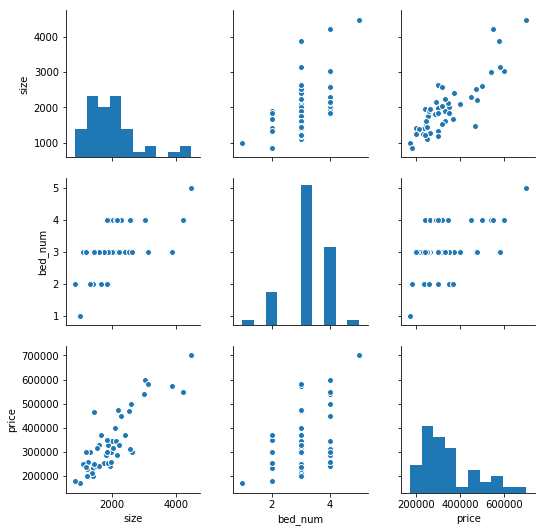

In [52]:
sns.pairplot(df);

## Define Variables

In [53]:
X = df.iloc[:, 0:-1]

In [54]:
y = df.iloc[:, -1]

## Standardize Data

In [55]:
X_std = pd.DataFrame()

for feature in X.columns:
    X_mean = np.mean(X[feature])
    X_sigma = np.std(X[feature])
    X_std[feature] = (X[feature] - X_mean) / X_sigma

In [56]:
X_std.head()

,size,bed_num
0,0.131415,-0.226093
1,-0.509641,-0.226093
2,0.507909,-0.226093
3,-0.743677,-1.554392
4,1.271071,1.102205


In [57]:
scaler = StandardScaler()

In [58]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [59]:
X_scaled = scaler.transform(X)

In [60]:
X_scaled[0:5]

array([[ 0.13141542, -0.22609337],
       [-0.5096407 , -0.22609337],
       [ 0.5079087 , -0.22609337],
       [-0.74367706, -1.5543919 ],
       [ 1.27107075,  1.10220517]])

## Normalize Data

In [61]:
X_norm = pd.DataFrame()

for feature in X.columns:
    X_min = min(X[feature])
    X_max = max(X[feature])
    X_norm[feature] = (X[feature] - X_min) / (X_max - X_min)

In [62]:
X_norm.head()

,size,bed_num
0,0.345284,0.50
1,0.206288,0.50
2,0.426917,0.50
3,0.155543,0.25
4,0.592388,0.75


In [63]:
scaler = MinMaxScaler()

In [64]:
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [65]:
X_scaled = scaler.transform(X)

In [66]:
X_scaled[0:5]

array([[0.34528406, 0.5       ],
       [0.20628792, 0.5       ],
       [0.42691671, 0.5       ],
       [0.1555433 , 0.25      ],
       [0.59238831, 0.75      ]])

# Linear Regression Model

In [67]:
lin_reg = LinearRegression()

### Cross Validation

In [68]:
scores = model_selection.cross_val_score(lin_reg, X_scaled, y, cv=3)

In [69]:
np.mean(scores)

0.6732866493999629

### Final Model

In [70]:
lin_reg.fit(X_scaled, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
lin_reg.score(X_scaled, y)

0.7329450180289143

In [72]:
predicts = lin_reg.predict(X_scaled)

### Plot predictions vs features

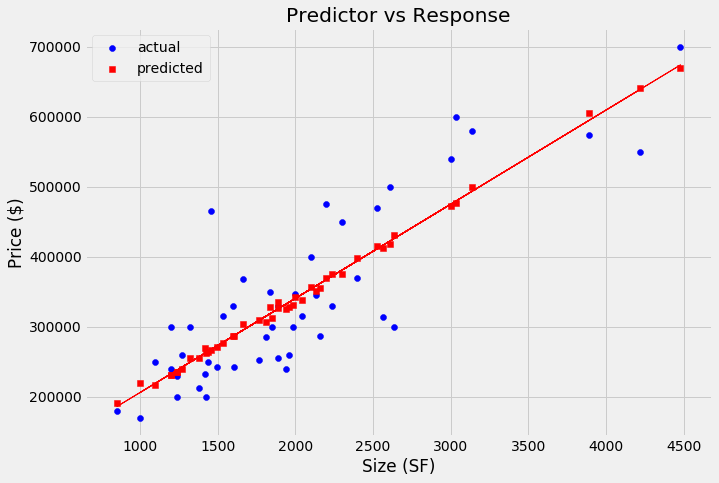

In [73]:
pred_plot(X.iloc[:, 0], 'Size (SF)', y, 'Price ($)', predicts)

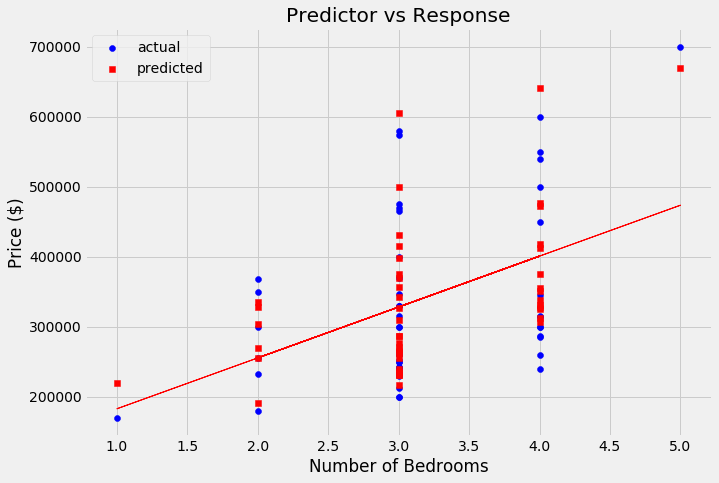

In [74]:
pred_plot(X.iloc[:, 1], 'Number of Bedrooms', y, 'Price ($)', predicts)

### Plot confidence interval of prediction for each feature

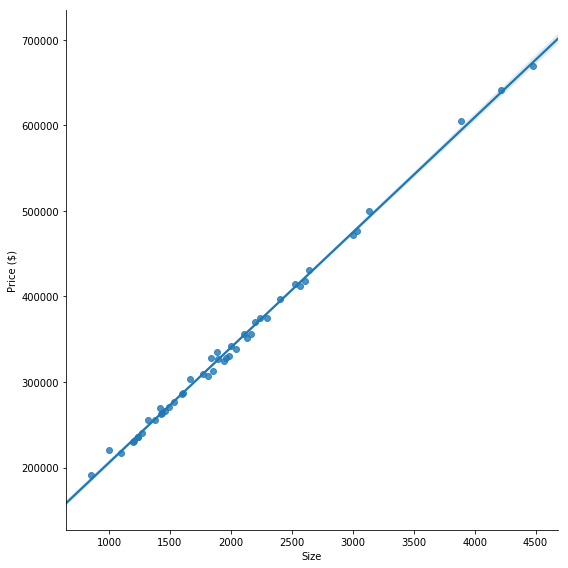

In [75]:
size_pred = pd.DataFrame(data={'Size': df['size'], 'Price ($)': predicts})
sns.lmplot(x='Size', y='Price ($)', data=size_pred, size=8);

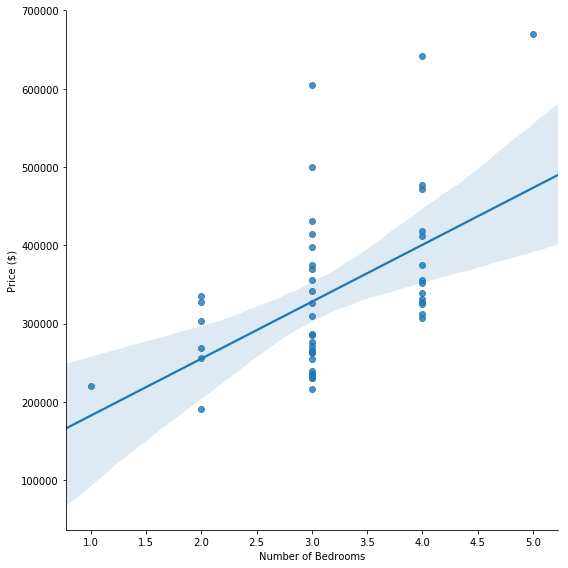

In [76]:
bed_pred = pd.DataFrame(data={'Number of Bedrooms': df['bed_num'], 'Price ($)': predicts})
sns.lmplot(x='Number of Bedrooms', y='Price ($)', data=bed_pred, size=8);

### Plot Residuals

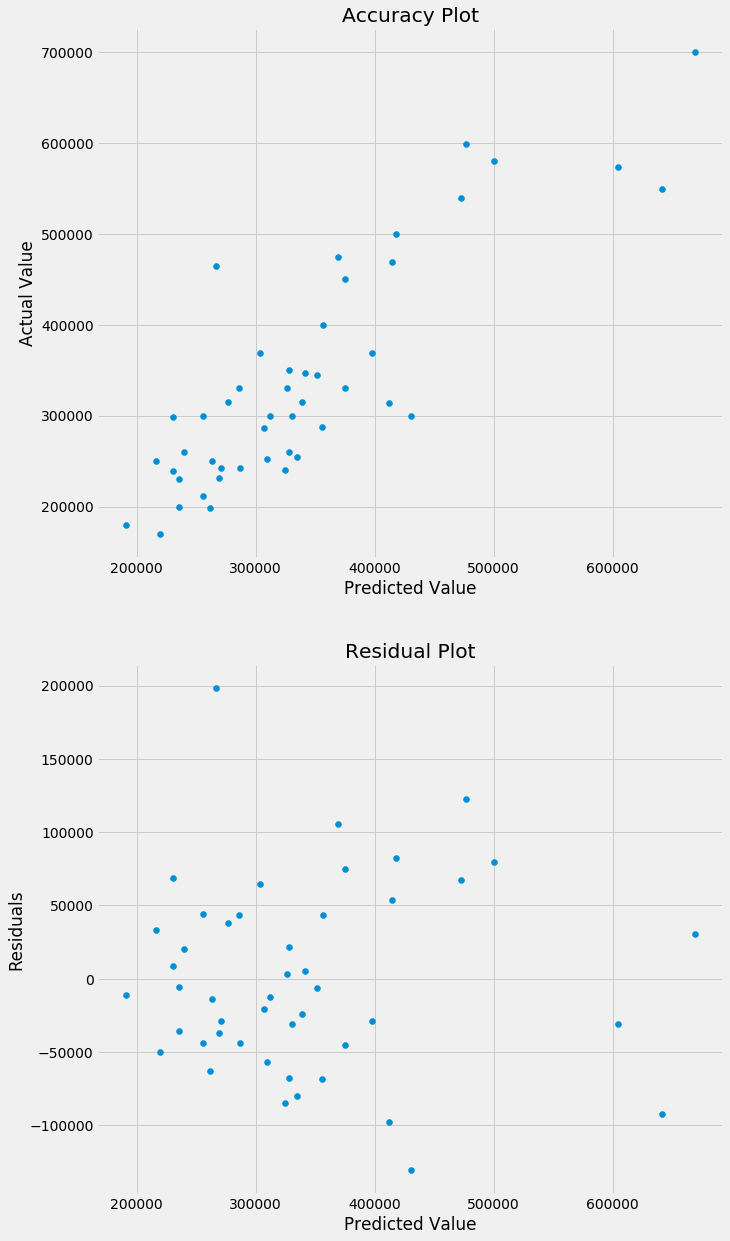

In [77]:
res_plot(y, predicts)

### Q-Q Plot

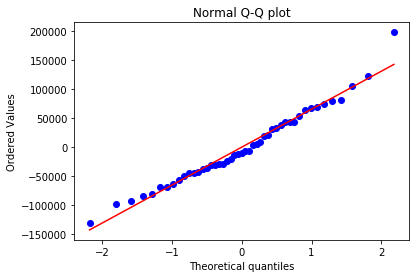

In [78]:
stats.probplot(y - predicts, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

# Concrete Example

## Data

In [79]:
df_conc = pd.read_csv('data/Concrete_Data.csv')

In [80]:
df_conc.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
sns.pairplot(df_conc, size=5);

In [ ]:
X = df_conc.iloc[:, 0:-1]
y = df_conc.iloc[:, -1]

In [ ]:
X.head()

## Test/train Split

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=0.2, 
                                                                    random_state=42)

In [ ]:
X_train.head()

## Scale

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)

In [ ]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled[0:5]

## Model

Initial linear regression model with cross validation

In [ ]:
conc_reg = LinearRegression()

In [ ]:
scores = model_selection.cross_val_score(conc_reg, X_train_scaled, y_train, cv=10)

In [ ]:
scores

In [ ]:
np.mean(scores)

In [ ]:
conc_reg.fit(X_train_scaled, y_train)

In [ ]:
conc_reg.score(X_test_scaled, y_test)

In [ ]:
conc_preds = conc_reg.predict(X_test_scaled)

In [ ]:
observations = np.random.choice(X_test.index, 10, replace=False)
actual = y_test[observations]
predicted = pd.Series(conc_preds, index=y_test.index)[observations]
observations = observations.astype(str)

In [ ]:
act_v_pred(observations, actual, predicted, 'Conc Strength (MPa)')

In [ ]:
pred_plot(X_test.iloc[:, 0], 'Cement Wgt (kg)', y_test, 'Conc Strength (MPa)', conc_preds)

In [ ]:
res_plot(y_test, conc_preds)

## Refine Model
Try polynomial modeling to better fit data

In [ ]:
poly_mod = PolynomialFeatures(degree=3)

In [ ]:
poly_mod.fit(X_train_scaled)

In [ ]:
X_train_poly = poly_mod.transform(X_train_scaled)

In [ ]:
X_test_poly = poly_mod.transform(X_test_scaled)

In [ ]:
conc_reg = LinearRegression()

In [ ]:
scores = model_selection.cross_val_score(conc_reg, X_train_poly, y_train, cv=10)
scores

In [ ]:
np.mean(scores)

In [ ]:
conc_reg.fit(X_train_poly, y_train)

In [ ]:
conc_reg.score(X_train_poly, y_train)

In [ ]:
conc_reg.score(X_test_poly, y_test)

In [ ]:
conc_preds = conc_reg.predict(X_test_poly)

In [ ]:
observations = np.random.choice(X_test.index, 10, replace=False)
actual = y_test[observations]
predicted = pd.Series(conc_preds, index=y_test.index)[observations]
observations = observations.astype(str)

In [ ]:
act_v_pred(observations, actual, predicted, 'Conc Strength (MPa)')

In [ ]:
pred_plot(X_test.iloc[:, 0], 'Cement Wgt (kg)', y_test, 'Conc Strength (MPa)', conc_preds)

In [ ]:
pred_plot(X_test.iloc[:, 3], 'Water Wgt (kg)', y_test, 'Conc Strength (MPa)', conc_preds)

In [ ]:
pred_plot(X_test.iloc[:, -1], 'Age (days)', y_test, 'Conc Strength (MPa)', conc_preds)

In [ ]:
res_plot(y_test, conc_preds)

## Regularization
Try refining an overfit model

In [ ]:
poly_mod = PolynomialFeatures(degree=4)

In [ ]:
poly_mod.fit(X_train_scaled)

In [ ]:
X_train_poly = poly_mod.transform(X_train_scaled)

In [ ]:
X_test_poly = poly_mod.transform(X_test_scaled)

In [ ]:
conc_reg = LinearRegression()

In [ ]:
scores = model_selection.cross_val_score(conc_reg, X_train_poly, y_train, cv=10)
scores

In [ ]:
np.mean(scores)

In [ ]:
conc_reg.fit(X_train_poly, y_train)

In [ ]:
conc_reg.score(X_train_poly, y_train)

In [ ]:
conc_reg.score(X_test_poly, y_test)

### Ridge

In [ ]:
n_steps = 50
alphas = np.linspace(0.1, 100, n_steps)

In [ ]:
re_mod = RegularizeLRModel(X_train_poly, y_train, alphas)

In [ ]:
re_mod.val_score()

In [ ]:
b_alpha = re_mod.best_alpha

In [ ]:
re_mod.val_curve()

### Final Model
Test model using best alpha from cross validation

In [ ]:
reg_model = linear_model.Ridge(alpha=b_alpha)
reg_model.fit(X_train_poly, y_train)

In [ ]:
reg_model.score(X_test_poly, y_test)

## Interpret Feature Effects

In [ ]:
feat_imp = list(zip(poly_mod.get_feature_names(X.columns), reg_model.coef_))

In [ ]:
feat_imp = sorted(feat_imp, key = lambda x: abs(x[1]), reverse=True)[:10]

In [ ]:
feat_imp

In [ ]:
feat_names = list(zip(*feat_imp))[0]
feat_names

In [ ]:
feat_coefs = list(zip(*feat_imp))[1]
feat_coefs

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.bar(feat_names, feat_coefs)
ax.set_title('Feature Importance')
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient');